In [1]:
import numpy as np

import json
# from keras.applications.inception_v3 import InceptionV3,preprocess_input
# from keras.applications.vgg16 import VGG16,preprocess_input
# from keras.applications.vgg19 import VGG19,preprocess_input

from keras.applications.xception import Xception,preprocess_input
# from keras.applications.resnet50 import ResNet50,preprocess_input

from keras.models import Model, load_model
from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

def single_feature_extract(filename) :
        model = Xception()
        # model = ResNet50(weights='imagenet')
        model.layers.pop()
        model = Model(input=model.inputs, outputs=model.layers[-1].output)
        image = load_img(filename,target_size=(model.input_shape[1],model.input_shape[2]))
        image = img_to_array(image)
        image = np.expand_dims(image,axis=0)
        image = preprocess_input(image)
        feature = model.predict(image)
        return feature

def greedy_search(model,photo_file,max_len):
        in_text = 'startseq'
        photo = single_feature_extract(photo_file)
        # photo = np.reshape(photo,photo.shape[1])
        with open('word_to_ix.json', 'r') as f:
            word_to_ix = json.load(f)
        with open('ix_to_word.json', 'r') as f:
            ix_to_word = json.load(f)  
        ix_to_word = { int(i) : w for i,w in ix_to_word.items()}    
        word_to_ix = { w : int(i) for w,i in word_to_ix.items()}   
        print(photo.shape,type(photo))
        print(word_to_ix['endseq'])
        for i in range(max_len) :
            seq = [word_to_ix[w] for w in in_text.split() if w in word_to_ix] 
            seq = pad_sequences([seq],maxlen=max_len)
            yhat = model.predict([photo, seq])
            yhat = np.argmax(yhat)
            word = ix_to_word[yhat]
            in_text += ' ' + word
            if word=='endseq':
                break
        print(max_len)    
        final = in_text.split()
        final = final[1:-1]
        final = ' '.join(final)
        return final

def beam_search_predictions(loaded_model,image,max_len,beam_index = 3):
    with open('word_to_ix.json', 'r') as f:
        word_to_ix = json.load(f)
    with open('ix_to_word.json', 'r') as f:
        ix_to_word = json.load(f) 
    ix_to_word = { int(i) : w for i,w in ix_to_word.items()}    
    word_to_ix = { w : int(i) for w,i in word_to_ix.items()}     
    start = [word_to_ix["startseq"]]
    start_word = [[start, 0.0]]
    e = single_feature_extract(image)
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = loaded_model.predict([np.array(e), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    start_word = start_word[-1][0]
    intermediate_caption = [ix_to_word[i] for i in start_word]
    final_caption = []
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption

if __name__ == "__main__":
    loaded_model = load_model('model-9_xception\model-ep001-loss3.283-val_loss3.734.h5')
    description = beam_search_predictions(loaded_model,'pp.jfif',34)
    im = plt.imread('pp.jfif')
    plt.imshow(im) 
    plt.xlabel(description)


Using TensorFlow backend.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Text(0.5, 0, 'man and woman are sitting on the street')

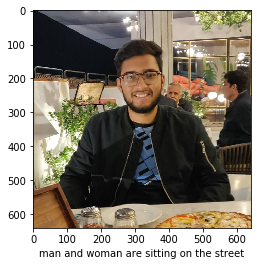

In [2]:
loaded_model = load_model('model-9_xception\model-ep001-loss3.283-val_loss3.734.h5')
description = beam_search_predictions(loaded_model,'pp.jfif',34)
im = plt.imread('pp.jfif')
plt.imshow(im) 
plt.xlabel(description) 


(1, 2048) <class 'numpy.ndarray'>
1382
34


Text(0.5, 0, 'man is sitting on the table of the table')

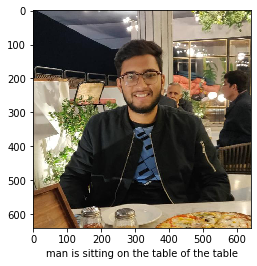

In [3]:
description = greedy_search(loaded_model,'pp.jfif',34)
im = plt.imread('pp.jfif')
plt.imshow(im) 
plt.xlabel(description)


Text(0.5, 0, 'group of people are sitting in front of building')

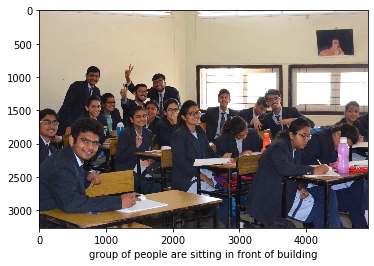

In [4]:
description = beam_search_predictions(loaded_model,'DSC_1531_2.JPG',34)
im = plt.imread('DSC_1531_2.JPG')
plt.imshow(im) 
plt.xlabel(description)


(1, 2048) <class 'numpy.ndarray'>
1382
34


Text(0.5, 0, 'man in red shirt is standing in front of crowd')

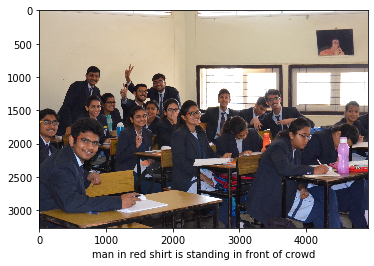

In [5]:
description = greedy_search(loaded_model,'DSC_1531_2.JPG',34)
im = plt.imread('DSC_1531_2.JPG')
plt.imshow(im) 
plt.xlabel(description)


Text(0.5, 0, 'group of children are playing soccer in the grass')

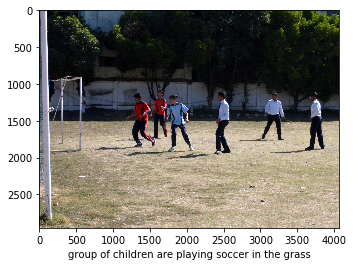

In [6]:
description = beam_search_predictions(loaded_model,'DSC_1809.JPG',34)
im = plt.imread('DSC_1809.JPG')
plt.imshow(im) 
plt.xlabel(description)


(1, 2048) <class 'numpy.ndarray'>
1382
34


Text(0.5, 0, 'two men are playing soccer on the beach')

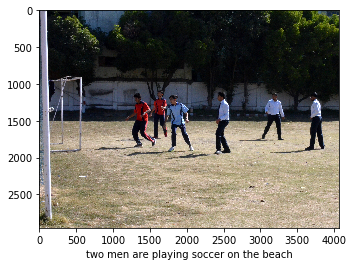

In [7]:
description = greedy_search(loaded_model,'DSC_1809.JPG',34)
im = plt.imread('DSC_1809.JPG')
plt.imshow(im) 
plt.xlabel(description)


Text(0.5, 0, 'group of people are playing soccer')

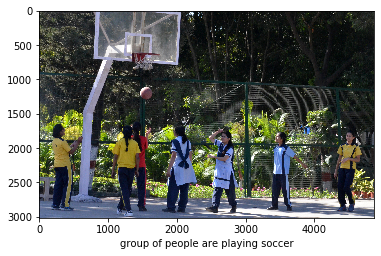

In [8]:
description = beam_search_predictions(loaded_model,'DSC_1810.JPG',34)
im = plt.imread('DSC_1810.JPG')
plt.imshow(im) 
plt.xlabel(description)


(1, 2048) <class 'numpy.ndarray'>
1382
34


Text(0.5, 0, 'two men are playing soccer on the street')

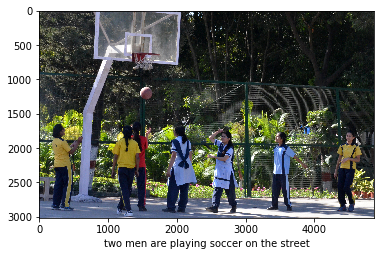

In [9]:
description = greedy_search(loaded_model,'DSC_1810.JPG',34)
im = plt.imread('DSC_1810.JPG')
plt.imshow(im) 
plt.xlabel(description)
